In [38]:
import sys
import os
import time
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/public/workspace/ruru_97/projects/schgnn/csMAHN')
import utils.preprocess as pp
from utils.utility import *
from utils.train import Trainer
from utils.plot import plot_umap

import importlib as im
im.reload(pp)

<module 'utils.preprocess' from '/public/workspace/ruru_97/projects/schgnn/csMAHN/utils/preprocess.py'>

In [15]:
reverse=False
aligned=False
tissue = "lung"
gse_ids = ["GSE127465","GSE127465"]
species = ('human', 'mouse')
dsnames = ('human_t', 'mouse_t')
path_data='/public/workspace/ruru_97/projects/data'
resdir='/public/workspace/ruru_97/projects/schgnn/result'
homo_method='biomart'
key_class='cell_type'
n_hvgs=2000
n_degs=50

seed = 123
stages=[200, 200, 200]
nfeats=64  # enbedding size #128
hidden=64 # 128
input_drop=0.2
att_drop=0.2
residual=True

threshold=0.9 # 0.8
lr=0.01  # lr = 0.01
weight_decay=0.001
patience=100
enhance_gama=10
simi_gama=0.1 

In [4]:
# reverse reference to query, query to reference.
if reverse:
    gse_ids = gse_ids[::-1]
    species = species[::-1]
    dsnames = dsnames[::-1]
seed_all(seed)
path_homo = f'{path_data}/homo/{homo_method}/input/{species[0]}_to_{species[1]}.txt'
path_specie_1 = f'{path_data}/ByTissue/{tissue}/{gse_ids[0]}/input/{dsnames[0]}.h5ad'
path_specie_2 = f'{path_data}/ByTissue/{tissue}/{gse_ids[1]}/input/{dsnames[1]}.h5ad'

# make file to save
time_tag = make_nowtime_tag()
curdir = f'{resdir}/{tissue}/{tissue}-{gse_ids[0]}_{dsnames[0]}-{gse_ids[1]}_{dsnames[1]}-{time_tag}'
model_dir = os.path.join(curdir, 'model_')
figdir = os.path.join(curdir, 'fig_')
os.mkdir(curdir)
os.mkdir(figdir)
os.mkdir(model_dir)
checkpt_file = model_dir + "/mutistages"
print(checkpt_file)

for i in range(len(stages)):
    res_dir = os.path.join(curdir, f'res_{i}')
    os.mkdir(res_dir)
homo = pd.read_csv(path_homo)
adata_species_1 = sc.read_h5ad(path_specie_1)
adata_species_2 = sc.read_h5ad(path_specie_2)

if aligned:
    adata_species_1, adata_species_2 = pp.aligned_type([adata_species_1, adata_species_2], 'cell_type')

print(
    f'Task: refernece:{gse_ids[0]}_{dsnames[0]} {adata_species_1.shape[0]} cells x {adata_species_1.shape[1]} gene -> query:{gse_ids[1]}_{dsnames[1]} {adata_species_2.shape[0]} cells x {adata_species_2.shape[1]} gene in {tissue}')

/public/workspace/ruru_97/projects/schgnn/result/lung/lung-GSE127465_human_t-GSE127465_mouse_t-03-03-09.05.35/model_/mutistages
Task: refernece:GSE127465_human_t 40362 cells x 41861 gene -> query:GSE127465_mouse_t 9201 cells x 28205 gene in lung


In [39]:
label1 = adata_species_1.obs[key_class].tolist()
label2 = adata_species_2.obs[key_class].tolist()

Homolog information follows
Mouse homology type
ortholog_one2one      16612
ortholog_many2many     5356
ortholog_one2many      3174
Name: count, dtype: int64


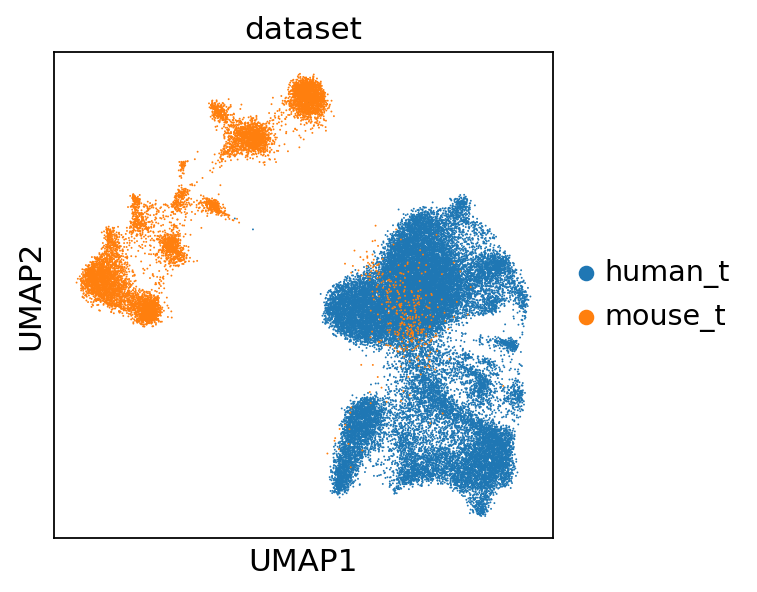

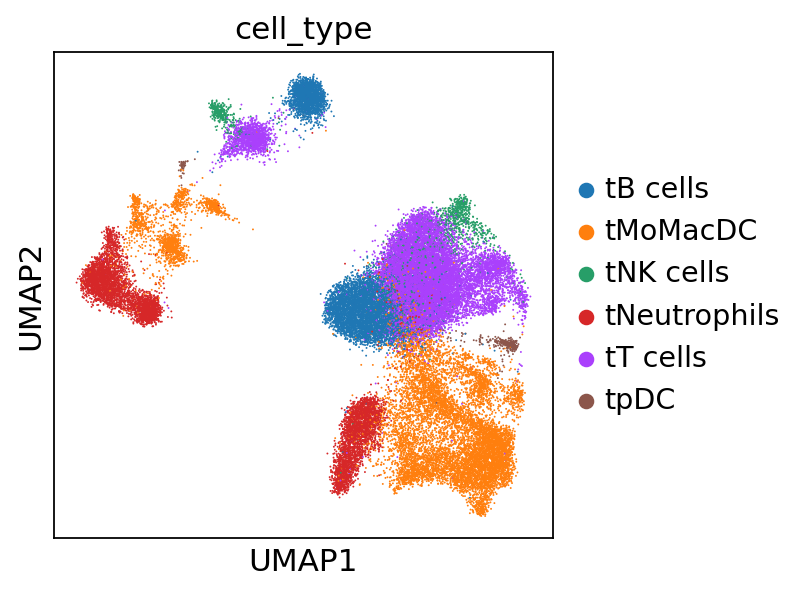

In [6]:
one2one,_ = pp.biomart_process(homo)
one2one_genes = pp.get_one2one_gene([adata_species_1,adata_species_2], one2one)
adatas = [adata_species_1,adata_species_2]
adata_aligned_1 = adatas[0][:,np.array(one2one_genes[0])]
adata_aligned_2 = adatas[1][:,np.array(one2one_genes[1])]
adatas[0].obs['dataset'], adata[1].obs['dataset'] = dsnames

data = sc.AnnData(  np.vstack([adata_aligned_1.X,adata_aligned_2.X]),
                    obs=pd.concat([adatas[0].obs,adatas[1].obs]),
                    var=np.array(one2one_genes[0]))


sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
data.raw = data
data = data[:, data.var.highly_variable]
sc.pp.scale(data, max_value=10)
sc.tl.pca(data, svd_solver='arpack')

sc.set_figure_params(dpi_save=200)
sc.pp.neighbors(data, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(data)

sc.pl.umap(data, color='dataset', save='_dataset.png')
sc.pl.umap(data, color='cell_type', save='_umap.png')


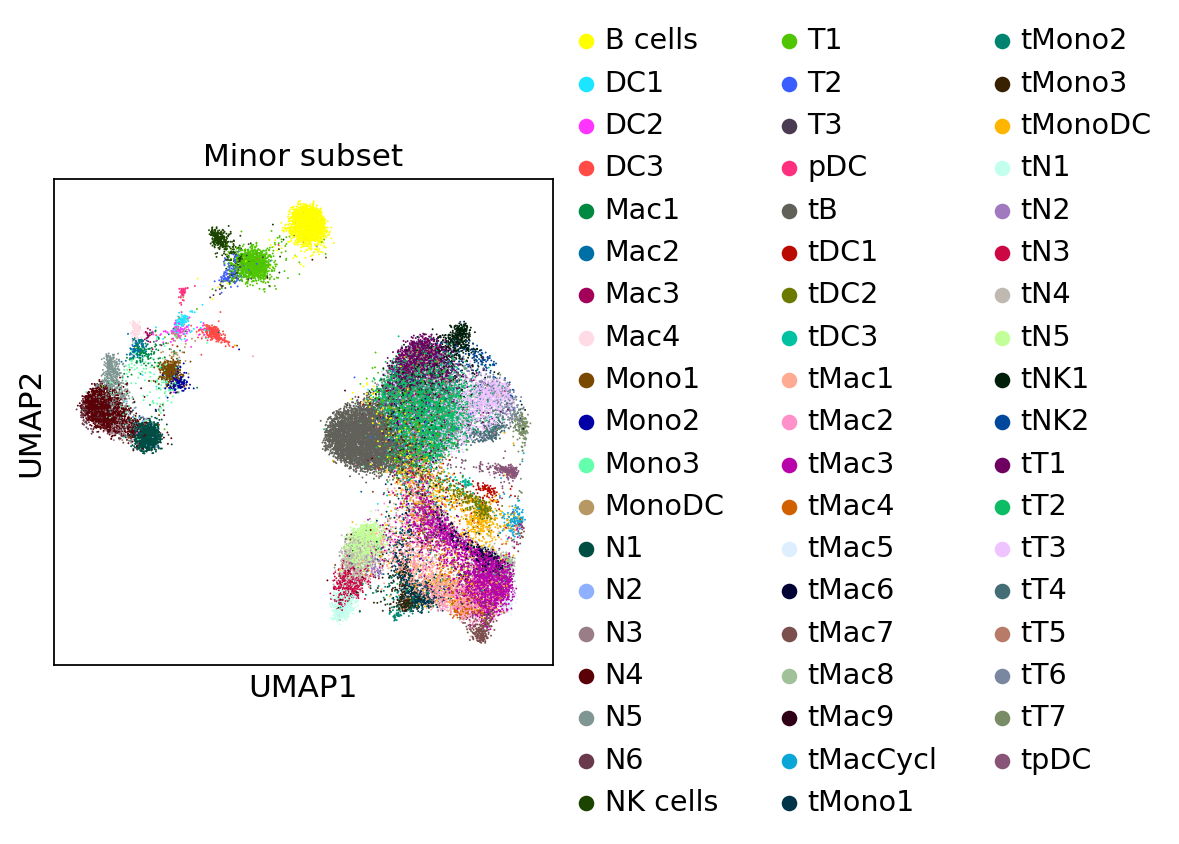

In [19]:
sc.pl.umap(data, color='Minor subset', save='_umap.png')